In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
from skimpy import skim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [2]:
df_old=pd.read_csv('/home/senku/Bureau/Fouille_D/Projet/data/TMDB  IMDB Movies Dataset.csv')

In [ ]:
df_old['release_date'] = pd.to_datetime(df_old['release_date'], format='%Y-%m-%d', errors='coerce')

# Extraire des informations temporelles
df_old['release_year'] = df_old['release_date'].dt.year
df_old['release_month'] = df_old['release_date'].dt.month
df_old['averageRating'] = df_old['averageRating'].round(1)

In [8]:
df_old.columns

Index(['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date',
       'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage',
       'tconst', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'tagline', 'genres',
       'production_companies', 'production_countries', 'spoken_languages',
       'keywords', 'directors', 'writers', 'averageRating', 'numVotes', 'cast',
       'release_year', 'release_month'],
      dtype='object')

In [4]:
df_supp = df_old.drop(columns=['title','vote_count', 'status', 'backdrop_path', 'homepage', 'tconst', 'original_title', 'popularity'
                          , 'poster_path', 'tagline', 'numVotes','revenue', 'overview', 'keywords', 'adult', 'budget', 'spoken_languages'])

In [12]:
df_supp.columns

Index(['id', 'vote_average', 'release_date', 'runtime', 'original_language',
       'genres', 'production_companies', 'production_countries', 'directors',
       'writers', 'averageRating', 'cast', 'release_year', 'release_month'],
      dtype='object')

In [5]:
df_supp = df_supp[(df_supp['runtime'] > 5) & (df_supp['runtime'] < 200)]  # Conserver des durées plausibles 
df_supp2 = df_supp[df_supp['vote_average'] != 0.0]      # Filtre les lignes avec vote_average != 0.0

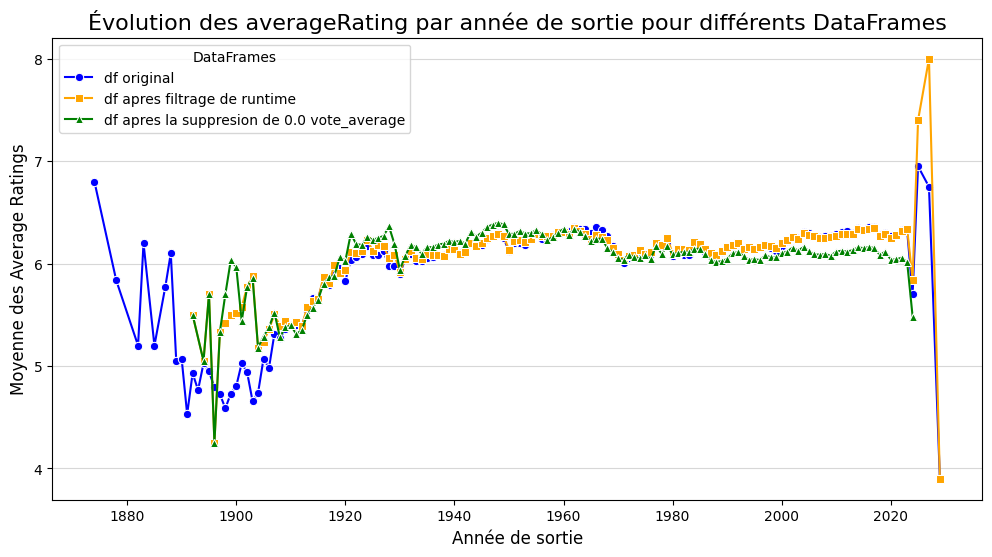

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Préparer les données pour df_old
df_t_old = df_old.dropna(subset=['release_year', 'averageRating'])
grouped_old = df_t_old.groupby('release_year')['averageRating'].mean().reset_index()

# Préparer les données pour df_supp
df_t_supp = df_supp.dropna(subset=['release_year', 'averageRating'])
grouped_supp = df_t_supp.groupby('release_year')['averageRating'].mean().reset_index()

# Préparer les données pour df_supp2
df_t_supp2 = df_supp2.dropna(subset=['release_year', 'averageRating'])
grouped_supp2 = df_t_supp2.groupby('release_year')['averageRating'].mean().reset_index()

# Tracer les graphiques
plt.figure(figsize=(12, 6))

# df_old
sns.lineplot(data=grouped_old, x='release_year', y='averageRating', marker='o', label='df original', color='blue')

# df_supp
sns.lineplot(data=grouped_supp, x='release_year', y='averageRating', marker='s', label='df apres filtrage de runtime', color='orange')

# df_supp2
sns.lineplot(data=grouped_supp2, x='release_year', y='averageRating', marker='^', label='df apres la suppresion de 0.0 vote_average', color='green')

# Personnalisation des axes et du titre
plt.title('Évolution des averageRating par année de sortie pour différents DataFrames', fontsize=16)
plt.xlabel('Année de sortie', fontsize=12)
plt.ylabel('Moyenne des Average Ratings', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.legend(title='DataFrames')
plt.show()


In [6]:
print(df_old['runtime'].count())
print(df_supp['runtime'].count())
print(df_supp2['runtime'].count())

438757
363868
240331


In [36]:
df_supp.count()

id                      363868
vote_average            363868
release_date            353424
runtime                 363868
original_language       363868
genres                  310383
production_companies    233529
production_countries    281584
directors               356549
writers                 311799
averageRating           363868
cast                    312624
release_year            353424
release_month           353424
dtype: int64

In [9]:
df_filtre = df_supp[(df_supp['release_year'] >= 1920) & (df_supp['release_year'] <= 2020)]

In [10]:
df_filtre.count()

id                      318626
vote_average            318626
release_date            318626
runtime                 318626
original_language       318626
genres                  276274
production_companies    208825
production_countries    254052
directors               312429
writers                 273675
averageRating           318626
cast                    278452
release_year            318626
release_month           318626
dtype: int64

In [11]:
df_filtre2 = df_filtre[~((df_filtre['genres'].isna()) & (df_filtre['production_countries'].isna()))]
df_filtre2.count()

id                      294270
vote_average            294270
release_date            294270
runtime                 294270
original_language       294270
genres                  276274
production_companies    206821
production_countries    254052
directors               288955
writers                 255034
averageRating           294270
cast                    263391
release_year            294270
release_month           294270
dtype: int64

In [13]:
# Remplacer les valeurs NaN par 'Unknown' pour les colonnes textuelles
columns_to_fill = ['genres', 'production_countries', 'directors', 'writers', 'cast' , 'production_companies']
df_filtre2[columns_to_fill] = df_filtre2[columns_to_fill].fillna('Unknown')

/tmp/ipykernel_5907/3550891352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtre2[columns_to_fill] = df_filtre2[columns_to_fill].fillna('Unknown')


In [14]:
df_supp3 = df_supp[~((df_supp['genres'].isna()) )]
df_supp3 = df_supp3[~((df_supp3['directors'].isna()) )]
df_supp3 = df_supp3[~((df_supp3['release_date'].isna()) )]
df_supp3 = df_supp3[~((df_supp3['cast'].isna()) )]
df_supp3 = df_supp3[~((df_supp3['writers'].isna()) )]

df_supp3.count()

id                      246391
vote_average            246391
release_date            246391
runtime                 246391
original_language       246391
genres                  246391
production_companies    186366
production_countries    216449
directors               246391
writers                 246391
averageRating           246391
cast                    246391
release_year            246391
release_month           246391
dtype: int64

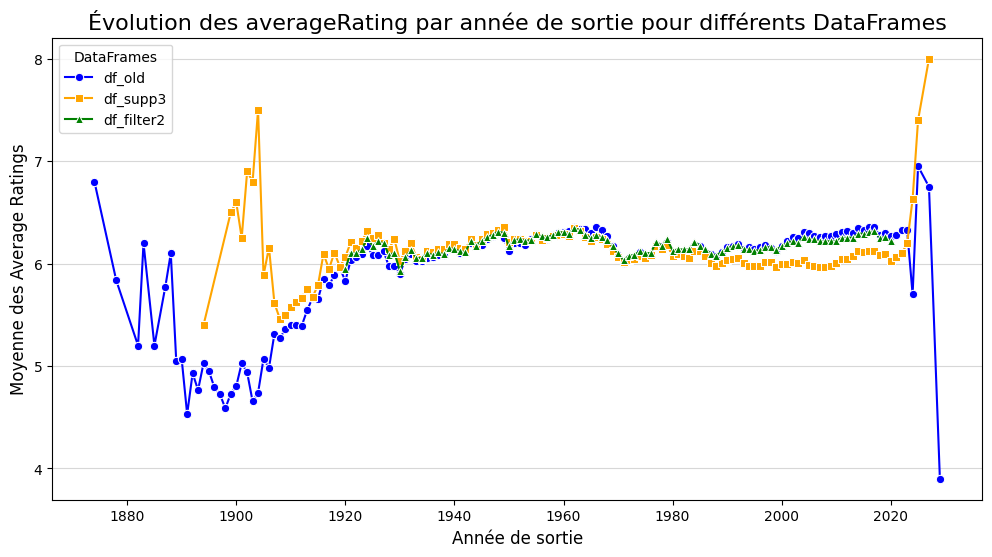

In [ ]:
df_t_old = df_old.dropna(subset=['release_year', 'averageRating'])
grouped_old = df_t_old.groupby('release_year')['averageRating'].mean().reset_index()

df_t_supp = df_supp3.dropna(subset=['release_year', 'averageRating'])
grouped_supp = df_t_supp.groupby('release_year')['averageRating'].mean().reset_index()

df_t_supp2 = df_filtre2.dropna(subset=['release_year', 'averageRating'])
grouped_supp2 = df_t_supp2.groupby('release_year')['averageRating'].mean().reset_index()

plt.figure(figsize=(12, 6))

# df_old
sns.lineplot(data=grouped_old, x='release_year', y='averageRating', marker='o', label='df_old', color='blue')

# df_supp3
sns.lineplot(data=grouped_supp, x='release_year', y='averageRating', marker='s', label='df_supp3', color='orange')

# df_filter2
sns.lineplot(data=grouped_supp2, x='release_year', y='averageRating', marker='^', label='df_filter2', color='green')

plt.title('Évolution des averageRating par année de sortie pour différents DataFrames', fontsize=16)
plt.xlabel('Année de sortie', fontsize=12)
plt.ylabel('Moyenne des Average Ratings', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.legend(title='DataFrames')
plt.show()

In [ ]:
#df=df_filtre2  
df=df_supp3   


## Préparation des colonnes 

1. TF-IDF pour genres

In [ ]:
tfidf_genres = TfidfVectorizer(tokenizer=lambda x: x.split(','), token_pattern=None, max_features=30)
genres_matrix = tfidf_genres.fit_transform(df['genres'].fillna(''))
genres_df = pd.DataFrame(genres_matrix.toarray(), columns=tfidf_genres.get_feature_names_out())


2. TF-IDF pour directors

In [ ]:
tfidf_directors = TfidfVectorizer(tokenizer=lambda x: x.split(','), token_pattern=None, max_features=40)
directors_matrix = tfidf_directors.fit_transform(df['directors'].fillna(''))
directors_df = pd.DataFrame(directors_matrix.toarray(), columns=tfidf_directors.get_feature_names_out())

3. TF-IDF pour cast

In [ ]:

tfidf_cast = TfidfVectorizer(tokenizer=lambda x: x.split(','), token_pattern=None, max_features=50)
cast_matrix = tfidf_cast.fit_transform(df['cast'].fillna(''))
cast_df = pd.DataFrame(cast_matrix.toarray(), columns=tfidf_cast.get_feature_names_out())

4. TF-IDF pour production_companies

In [ ]:

tfidf_companies = TfidfVectorizer(tokenizer=lambda x: x.split(','), token_pattern=None, max_features=30)
companies_matrix = tfidf_companies.fit_transform(df['production_companies'].fillna(''))
companies_df = pd.DataFrame(companies_matrix.toarray(), columns=tfidf_companies.get_feature_names_out())

5. Frequency Encoding pour production_countries

In [ ]:
country_frequency = df['production_countries'].str.split(',').explode().value_counts(normalize=True)
df['production_countries_encoded'] = df['production_countries'].apply(
    lambda x: sum(country_frequency.get(country.strip(), 0) for country in x.split(',')) if pd.notna(x) else 0
)

6. One-Hot Encoding pour original_language_grouped

In [ ]:
threshold = 0.01 * len(df)  
frequent_languages = df['original_language'].value_counts()[df['original_language'].value_counts() > threshold].index

df['original_language_grouped'] = df['original_language'].apply(lambda x: x if x in frequent_languages else 'Other')

X_language = pd.get_dummies(df['original_language_grouped'], prefix='language', drop_first=True)

7. Colonnes numériques

In [ ]:

X_numeric = df[['release_year', 'release_month', 'runtime']]

Réduction de dimensionnalité avec PCA

In [ ]:
# PCA pour genres
pca_genres = PCA(n_components=10)
genres_pca = pca_genres.fit_transform(genres_df)
genres_pca_df = pd.DataFrame(genres_pca, columns=[f'genre_pca_{i+1}' for i in range(10)])

# PCA pour directors
pca_directors = PCA(n_components=10)
directors_pca = pca_directors.fit_transform(directors_df)
directors_pca_df = pd.DataFrame(directors_pca, columns=[f'director_pca_{i+1}' for i in range(10)])

# PCA pour cast
pca_cast = PCA(n_components=10)
cast_pca = pca_cast.fit_transform(cast_df)
cast_pca_df = pd.DataFrame(cast_pca, columns=[f'cast_pca_{i+1}' for i in range(10)])

# PCA pour production_companies
pca_companies = PCA(n_components=10)
companies_pca = pca_companies.fit_transform(companies_df)
companies_pca_df = pd.DataFrame(companies_pca, columns=[f'company_pca_{i+1}' for i in range(10)])


Combinaison des colonnes dans X

In [ ]:
X = pd.concat([
    genres_pca_df.reset_index(drop=True),         # Genres (après PCA)
    directors_pca_df.reset_index(drop=True),      # Directors (après PCA)
    cast_pca_df.reset_index(drop=True),           # Cast (après PCA)
    companies_pca_df.reset_index(drop=True),      # Production companies (après PCA)
    X_language.reset_index(drop=True),            # Original language (One-Hot Encoding)
    df[['production_countries_encoded']].reset_index(drop=True),  # Production countries (Frequency Encoding)
    X_numeric.reset_index(drop=True)              # Colonnes numériques
], axis=1)

y = df['averageRating']


Modele Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


Évaluation  

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R² Score:", r2)

In [62]:
# Test avec différents nombres de composantes principales
for n in [5, 10, 15, 20, 25, 30]:
    pca_genres = PCA(n_components=n).fit_transform(genres_df)
    pca_directors = PCA(n_components=n).fit_transform(directors_df)
    
    # Créer X avec PCA
    genres_pca_df = pd.DataFrame(pca_genres, columns=[f'genre_pca_{i+1}' for i in range(n)])
    directors_pca_df = pd.DataFrame(pca_directors, columns=[f'director_pca_{i+1}' for i in range(n)])
    
    X_with_pca = pd.concat([
        genres_pca_df.reset_index(drop=True),
        directors_pca_df.reset_index(drop=True),
        X_language.reset_index(drop=True),
        X_numeric.reset_index(drop=True)
    ], axis=1)
    
    # Entraîner et évaluer
    train_and_evaluate(X_with_pca, y, f"With PCA (n_components={n})")


With PCA (n_components=5) Results:
MSE: 1.0485814398939126
R² Score: 0.31531356726209137
----------------------------------------
With PCA (n_components=10) Results:
MSE: 1.0465934859189776
R² Score: 0.3166116305919965
----------------------------------------
With PCA (n_components=15) Results:
MSE: 1.0433273099378677
R² Score: 0.31874432748717185
----------------------------------------
With PCA (n_components=20) Results:
MSE: 1.0431438053114321
R² Score: 0.31886414948981745
----------------------------------------
With PCA (n_components=25) Results:
MSE: 1.0421863159219464
R² Score: 0.31948935604939344
----------------------------------------
With PCA (n_components=30) Results:
MSE: 1.0404257130028416
R² Score: 0.3206389672157631
----------------------------------------
